## Transfer Learning

Learning to use a pre-trained model for faster development. Using shutil() as the main library to copy images vs. other methods in my other notebooks.

In [231]:
# Images
from PIL import Image
from skimage.io import imread
from skimage.transform import resize
import imgaug as aug
import imgaug.augmenters as imaug
import cv2

# Toolbox
from pathlib import Path
from imutils import paths
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Misc
import progressbar
import random
import glob
import shutil
import sys
import os
import warnings
warnings.filterwarnings(action='ignore')

# Deep learning
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from keras.models import Model
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras import applications
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img
from keras.applications.vgg16 import preprocess_input

# Evaluation
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

### Helpers

In [2]:
def pct_bar_labels():
    '''
    Function used to label the relative frequency on top of each bars
    '''
    # Set font size
    fs=15
    
    # Set plot label and ticks
    plt.ylabel('Relative Frequency (%)', fontsize=fs)
    plt.xticks(rotation=0, fontsize=fs)
    plt.yticks([])
    
    # Set individual bar labels in proportional scale
    for x in ax1.patches:
        ax1.annotate(str(x.get_height()) + '%', 
        (x.get_x() + x.get_width()/2., x.get_height()), ha='center', va='center', xytext=(0, 7), 
        textcoords='offset points', fontsize=fs, color='black')

def freq_table(var):
    '''
    Define plot global variables
    Create a function that will populate a frequency table (%)
    Get counts per feature then get the percentage over the total counts
    '''
    global ax, ax1
    
    # Get values and pct and combine it into a dataframe
    count_freq = var.value_counts()
    pct_freq = round(var.value_counts(normalize=True)*100, 2)
    
    # Create a dataframe
    df = pd.DataFrame({'Count': count_freq, 'Percentage': pct_freq})
    
    # Print variable name
    print('Frequency of', var.name, ':')
    display(df)
    
    # Create plot
    ax1 = pct_freq.plot.bar(title='Percentage of {}'.format(var.name), figsize=(12,8))
    ax1.title.set_size(15)
    pct_bar_labels()
    plt.show()
    
# Define a null function
def get_nulls(df):
    
    # Get null pct and counts
    null_cols = pd.DataFrame(df.isnull().sum().sort_values(ascending=False), columns=['Null Data Count'])
    null_cols_pct = pd.DataFrame(round(df.isnull().sum().sort_values(ascending=False)/len(df),2), columns=['Null Data Pct'])

    # Combine dataframes horizontally
    null_cols_df = pd.DataFrame(pd.concat([null_cols, null_cols_pct], axis=1))

    all_nulls = null_cols_df[null_cols_df['Null Data Pct']>0]

    # Print
    print('There are', len(all_nulls), 'columns with missing values.')
    return all_nulls

# Define plot_nulls function
def plot_nulls(train):
    # Get null pct and counts
    null_cols = pd.DataFrame(train.isnull().sum().sort_values(ascending=False), columns=['Null Data Count'])
    null_cols_pct = pd.DataFrame(round(train.isnull().sum().sort_values(ascending=False)/len(train),2)*100, columns=['Null Data %'])

    # Combine horizontally (axis=1) into a dataframe with column names (keys=[]) then to a data frame
    null_cols_df = pd.DataFrame(pd.concat([null_cols, null_cols_pct], axis=1))

    all_nulls = null_cols_df[null_cols_df['Null Data %']>0]

    # Create figure space
    plt.figure(figsize=(12, 8))

    # Create plot
    sns.barplot(x=all_nulls.index,
                y='Null Data %',
                data=all_nulls)

    # Set plot features
    plt.xticks(rotation='90')
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of Missing Values', fontsize=15)
    plt.title('Percent of Missing Data by Features', fontsize=15)
    plt.show()
    
# Show model history
def show_model_history(modelHistory, model_name, w=12, h=6):
    history = pd.DataFrame()
    history['Train Loss'] = modelHistory.history['loss']
    history['Validation Loss'] = modelHistory.history['val_loss']
    history['Train Accuracy'] = modelHistory.history['acc']
    history['Validation Accuracy'] = modelHistory.history['val_acc']
    history.plot(figsize=(w, h))
    plt.title('Model: {} - Train & Validation Loss & Accuracy'.format(model_name))
    plt.show()

### Set directory

In [3]:
# Set directory
PATH = 'C:\\Users\\' + os.getlogin() + '\\Documents\\Programming\\DeepLearning\\09-dog-cat-classifier\\images'
os.chdir(PATH)

# Use Path
MAIN_PATH = Path(PATH)

# Path to train directory
train_dir = MAIN_PATH / 'original_train'

# Path to test directory
test_dir = MAIN_PATH / 'original_test'

# List file names
FILE_NAMES = os.listdir(train_dir)
FILE_NAMES[0:5]

['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.1000.jpg']

### Base directories

Using os.mkdir() to create multiple folders with class folders within the data type.

In [4]:
original_dataset_dir = train_dir

base_dir = MAIN_PATH

if not os.path.exists(base_dir):
    os.mkdir(base_dir)

### Trying out method in creating multiple folders (train, val, test)

In [5]:
train_dir = os.path.join(base_dir, 'train')
if not os.path.exists(train_dir):
    os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
if not os.path.exists(validation_dir):
    os.mkdir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
if not os.path.exists(test_dir):
    os.mkdir(test_dir)

train_cats_dir = os.path.join(train_dir, 'cats')
if not os.path.exists(train_cats_dir):
    os.mkdir(train_cats_dir)

train_dogs_dir = os.path.join(train_dir, 'dogs')
if not os.path.exists(train_dogs_dir):
    os.mkdir(train_dogs_dir)

validation_cats_dir = os.path.join(validation_dir, 'cats')
if not os.path.exists(validation_cats_dir):
    os.mkdir(validation_cats_dir)

validation_dogs_dir = os.path.join(validation_dir, 'dogs')
if not os.path.exists(validation_dogs_dir):
    os.mkdir(validation_dogs_dir)

test_cats_dir = os.path.join(test_dir, 'cats')
if not os.path.exists(test_cats_dir):
    os.mkdir(test_cats_dir)

test_dogs_dir = os.path.join(test_dir, 'dogs')
if not os.path.exists(test_dogs_dir):
    os.mkdir(test_dogs_dir)

### Looping through images

Dataset sizes:

- train: 1000
- validation: 500
- test: 500

Loop through certain amount of images by creating the file names in a loop then search through the directory and copy it to the new folder path.

In [6]:
# Copy cat images from training to new cat training folder
file_names = ['cat.{}.jpg'.format(i) for i in range(1000)] # create name for file

# Loop through file names created by searching the original data directory
for fname in file_names:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

In [7]:
file_names = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in file_names:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)

file_names = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in file_names:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)

file_names = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in file_names:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)

file_names = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in file_names:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)

file_names = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in file_names:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

### Define model params

In [8]:
# Define model parameters
EPOCHS = 30
BATCH_SIZE = 150
TARGET_SIZE = 150
WIDTH=150
HEIGHT=150

### Image augmentation

Use flow_from_directory()

In [38]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Notebook is using only rescale and not the same as train
val_datagen = ImageDataGenerator(
    rescale=1./255
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

# Set generation object path
train_gen = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(WIDTH, HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_gen = val_datagen.flow_from_directory(
    directory=validation_dir,
    target_size=(WIDTH, HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_gen = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(WIDTH, HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Callbacks

Used to save best model.

In [10]:
callbacks_list = [
    ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)
]

## Transfer Learning: Feature Extractor

---------------

Feature vectors are extracted from the images in the dataset, and these features are classified by supervised machine learning algorithms. Images are given to the CNN model, which makes classification without the feature extraction process.

CNN also allows for the use of pre-trained models on new datasets. This approach is called transfer learning. There are two types of transfer learning.
- Feature Extractor
- Fine Tuning

Transfer learning is based on the paradigm where a model was previously trained on the initial dataset can be used as a starting point on the new dataset. For example, a model that is trained for classification on snake and frog data can be used as a starting point for the classification of other animals. The models of the CNN architectures are trained on the ImageNet dataset and are available in the Keras library. These architectures can be easily used for the purpose of transfer learning on new data like this.

[ex](https://github.com/Madhivarman/python/blob/master/resnet_classification.ipynb)

### Load VGG16 model

In [11]:
vgg = applications.VGG16(weights='imagenet', include_top=False, input_shape=(WIDTH, HEIGHT, 3))
vgg.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
bloc

### Create new FCN layer

In [47]:
vgg.input

<tf.Tensor 'input_1:0' shape=(?, 150, 150, 3) dtype=float32>

In [12]:
vgg.outputs

[<tf.Tensor 'block5_pool/MaxPool:0' shape=(?, 4, 4, 512) dtype=float32>]

In [13]:
# Start with vgg output without the top layer and add Flatten()
x = vgg.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

### Create model

In [14]:
model = Model(inputs=vgg.input, outputs=outputs)

### Trainable = False (new)

Need to read up documentation and examples on this part.

In [15]:
for layer in vgg.layers:
    layer.trainable=False

In [16]:
vgg.layers

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

### Compile the model

In [18]:
model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=2e-5),
    metrics=['accuracy']
)

### Fit the model

In [42]:
val_steps = val_gen.samples // BATCH_SIZE
epoch_steps = train_gen.samples // BATCH_SIZE
print(val_steps)
print(epoch_steps)

6
13


In [20]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch=100,
    epochs=EPOCHS,
    validation_data=val_gen,
    validation_steps=50,
    callbacks=callbacks_list
)

Epoch 1/30
100/100 [==============================] - 70s 702ms/step - loss: 0.3663 - acc: 0.8457 - val_loss: 0.2809 - val_acc: 0.8836
Epoch 2/30
100/100 [==============================] - 64s 643ms/step - loss: 0.3427 - acc: 0.8538 - val_loss: 0.2732 - val_acc: 0.8879
Epoch 3/30
100/100 [==============================] - 64s 643ms/step - loss: 0.3262 - acc: 0.8595 - val_loss: 0.2584 - val_acc: 0.8885
Epoch 4/30
100/100 [==============================] - 64s 644ms/step - loss: 0.3147 - acc: 0.8671 - val_loss: 0.2554 - val_acc: 0.8931
Epoch 5/30
100/100 [==============================] - 64s 641ms/step - loss: 0.3042 - acc: 0.8727 - val_loss: 0.2481 - val_acc: 0.8987
Epoch 6/30
100/100 [==============================] - 64s 637ms/step - loss: 0.2950 - acc: 0.8739 - val_loss: 0.2490 - val_acc: 0.8978
Epoch 7/30
100/100 [==============================] - 64s 639ms/step - loss: 0.2882 - acc: 0.8755 - val_loss: 0.2483 - val_acc: 0.8979
Epoch 8/30
100/100 [==============================] - 6


========= Evaluation Metrics =========
Train Accuracy: 0.902
Validation Accuracy: 0.907
Mean Train Accuracy: 0.887
Mean Validation Accuracy: 0.901


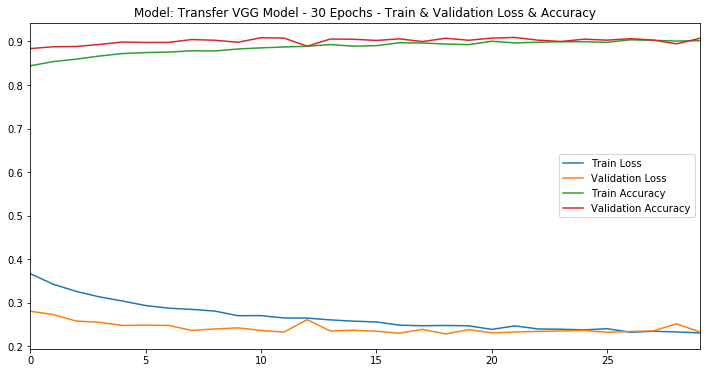

In [35]:
print('\n========= Evaluation Metrics =========')
print('Train Accuracy: {:.3f}'.format(history.history['acc'][-1]))
print('Validation Accuracy: {:.3f}'.format(history.history['val_acc'][-1]))
print('Mean Train Accuracy: {:.3f}'.format(pd.DataFrame(history.history['acc'])[0].mean().round(3)))
print('Mean Validation Accuracy: {:.3f}'.format(pd.DataFrame(history.history['val_acc'])[0].mean().round(3)))
show_model_history(modelHistory=history, model_name='Transfer VGG Model - 30 Epochs', w=12, h=6)

### Predict

The method predict expects to get a batch of images. You should run model.summary() to see what the expected dimensions of the input are. The batch size itself might have been designed to be flexible during training, by specifying None in the first dimension on the model input_shape parameter.

In [176]:
# X_test = []
# y_test = []

# for p in os.listdir(os.path.join(test_dir, 'cats'))[0:1]:
#     y_test.append(p.split('.')[0])
#     img = cv2.imread(os.path.join(test_dir, 'cats', p))
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = img.resize(WIDTH, HEIGHT, 3)
#     img = np.expand_dims(img, axis=0)
# #     img = img.reshape(-1, 150, 150, 3)
# #     img = img.astype('float32') / 255
#     X_test.append(img)

# for p in os.listdir(os.path.join(test_dir, 'dogs'))[0:1]:
#     y_test.append(p.split('.')[0])
#     img = cv2.imread(os.path.join(test_dir, 'dogs', p))
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = img.resize(WIDTH, HEIGHT, 3)
#     img = np.expand_dims(img, axis=0)
# #     img = img.reshape(-1, 150, 150, 3)    
# #     img = img.astype('float32') / 255
#     X_test.append(img)

In [177]:
# freq_table(pd.DataFrame(y_test)[0])

In [353]:
X_test = []
y_test = []

for p in os.listdir(os.path.join(test_dir, 'cats'))[0:251]:
    y_test.append(p.split('.')[0])
    img = load_img(os.path.join(test_dir, 'cats', p), target_size=(150, 150))
    img = img_to_array(img)
    img = preprocess_input(img)
    X_test.append(img)

for p in os.listdir(os.path.join(test_dir, 'dogs')):
    y_test.append(p.split('.')[0])
    img = load_img(os.path.join(test_dir, 'dogs', p), target_size=(150, 150))
    img = img_to_array(img)
    img = preprocess_input(img)    
    X_test.append(img)

In [354]:
print(y_test[0])
print(y_test[-1])

cat
dog


In [355]:
# le = LabelEncoder()
# y_test = le.fit_transform(y_test)

y_test = [0 if x == 'cat' else 1 for x in y_test]

In [356]:
y_test[0:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [357]:
pd.DataFrame(y_test)[0].value_counts()

1    500
0    251
Name: 0, dtype: int64

In [358]:
X_test_arr = np.array(X_test)
y_test_arr = np.array(y_test)

In [359]:
y_test_arr[0]

0

In [360]:
# Get prediction
prediction = model.predict(X_test_arr)

acc = accuracy_score(y_test_arr, np.round(prediction))*100
cm = confusion_matrix(y_test_arr, np.round(prediction))

print('Acc: ', acc)
print('CM:' )
cm

Acc:  83.08921438082557
CM:


array([[124, 127],
       [  0, 500]], dtype=int64)

In [361]:
pd.DataFrame(prediction.round())[0].value_counts()

1.0    627
0.0    124
Name: 0, dtype: int64

### Evaluation Metrics

========= Confusion Matrix =========


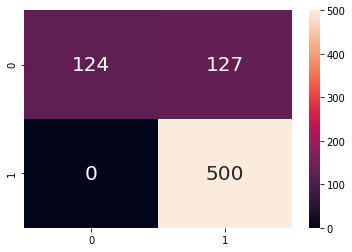


========= Evaluation Metrics =========
Accuracy: 83.089%
Precision: 100.000%
Recall: 49.402%
F1-score: 66.133%

========= Training Accuracy =========
Train acc: 90.19
FN:  127
Total:  751


In [362]:
tn = cm[1][1]
fp = cm[1][0]
fn = cm[0][1]
tp = cm[0][0]

print('========= Confusion Matrix =========')
sns.heatmap(cm, 
            annot=True,
            fmt='d',
            annot_kws={'size': 20})
plt.show()

print('\n========= Evaluation Metrics =========')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {:.3f}%'.format(acc))
print('Precision: {:.3f}%'.format(precision))
print('Recall: {:.3f}%'.format(recall))
print('F1-score: {:.3f}%'.format(2*precision*recall/(precision+recall)))

print('\n========= Training Accuracy =========')
print('Train acc: {}'.format(np.round((history.history['acc'][-1])*100, 2)))
print('FN: ', fn)
print('Total: ', tn+fp+fn+tp)